In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from argparse import Namespace
from pathlib import Path
import numpy as np
import scipy.io as sio 

import torch
import torch.nn.functional as F

from turboflow.dataloaders import TurboFlowDataModule

from turboflow.utils import phy_utils as phy
from turboflow.utils import torch_utils as tch

import matplotlib.pyplot as plt

In [3]:
# load dataset
data_dir = Path('/','home','dicarlo_d','Documents','Datasets','Turb2D.hdf5')
dm = TurboFlowDataModule(dataset='Turb2D', 
                         data_dir=data_dir,
                         batch_size=100000,
                         time_idx=666,
                         train_downsampling_space=1,
                         val_downsampling_space=1,
                         test_downsampling_space=1,
                         train_downsampling_time=1,
                         val_downsampling_time=1,
                         test_downsampling_time=1,
                         train_shuffle=False,
                         val_shuffle=False,
                         test_shuffle=False,
                         num_workers=1)
dm.setup()

In [4]:
X_lr, y_lr = dm.val_dataset[:]
img_shape_lr = dm.val_dataset.img_shape[:2]
shape_lr = dm.val_dataset.img_shape
L = shape_lr[0]
N_lr = X_lr.shape[0]
print('Low Resolution data:', N_lr, L)

X_hr, y_hr = dm.test_dataset[:]
img_shape_hr = dm.test_dataset.img_shape[:2]
shape_hr = dm.test_dataset.img_shape
H = shape_hr[0]
N_hr = X_hr.shape[0]
print('High Resolution data:', N_hr, H)

Low Resolution data: 65536 256
High Resolution data: 65536 256


In [5]:
coords_lr = X_lr.reshape(256,256,2).numpy()
vels_lr = y_lr.reshape(256,256,2).numpy()

mat = {}
mat['coords'] = coords_lr
mat['vels'] = vels_lr

sio.savemat('./turb2D_sample666_xy_uv_256x256x2.mat', mat)
np.save('./turb2D_sample666_xy_uv_256x256x2.npy',mat)

(256, 256, 2)
<class 'numpy.ndarray'>


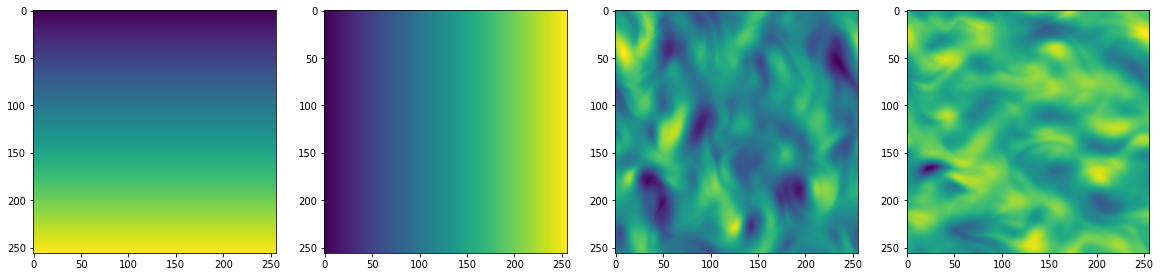

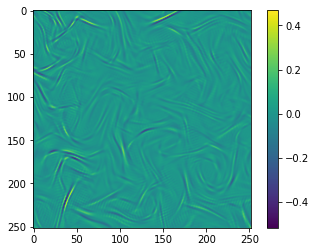

12.88503


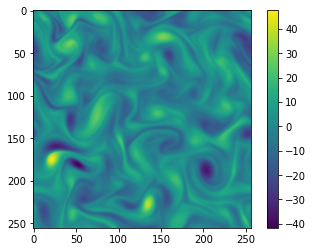

In [6]:
# compute and visualize divergence at highest scale
uv = vels_lr
xy = coords_lr
print(uv.shape)
print(type(uv))

x = xy[:,:,0]
y = xy[:,:,1]
u = uv[:,:,0]
v = uv[:,:,1]

plt.figure(figsize=(20,5))
plt.subplot(141)
plt.imshow(x)
plt.subplot(142)
plt.imshow(y)
plt.subplot(143)
plt.imshow(u)
plt.subplot(144)
plt.imshow(v)
plt.show()

D = phy.compute_divergence((x,y),(u,v))
D = D[2:-2,2:-2]
plt.imshow(D)
plt.colorbar()
plt.show()
print(np.linalg.norm(D))

W = phy.compute_vorticity((x,y),(u,v))
plt.imshow(W)
plt.colorbar()
plt.show()

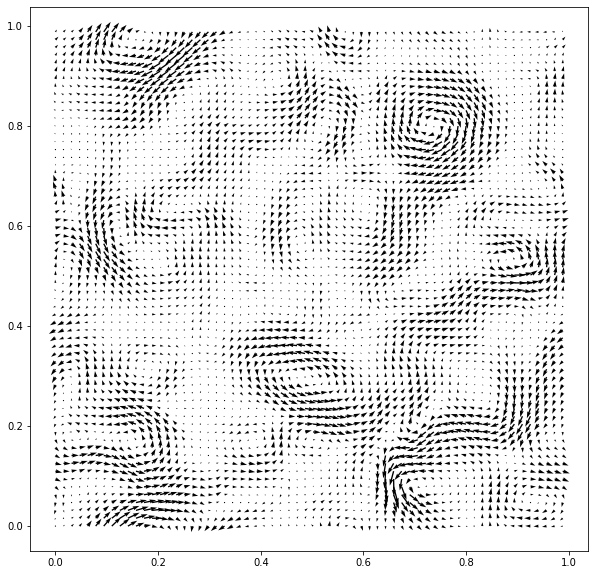

In [7]:
ds = 4
plt.figure(figsize=(10,10))
plt.quiver (x[::ds,::ds], y[::ds,::ds],
            u[::ds,::ds], v[::ds,::ds])
plt.show()

In [8]:
def decomposition(Ut,Vt,pad=5,type_pad='symmetric'):
    lig,col=Ut.shape
    U = np.pad(Ut, ((pad * lig,pad * lig),(pad * col,pad * col)),type_pad)
    V = np.pad(Vt, ((pad * lig,pad * lig),(pad * col,pad * col)),type_pad)
    nl, nc = U.shape
    
    beta = np.arange((-nl / 2 + 0.5), (nl / 2 - 0.5) + 1)
    beta = beta.reshape((nl,1))
    t = np.ones((1,nc))
    beta = np.dot(beta,t)

    alpha = np.arange((-nc / 2 + 0.5), (nc / 2 - 0.5) + 1)
    alpha = alpha.reshape((nc,1))
    t = np.ones((nl,1))
    alpha = np.dot(t,np.transpose(alpha))

    coef = 2*1j*np.pi/np.sqrt(nl*nc)
    Fu = np.fft.fftshift(np.fft.fft2(U, (nl, nc)))
    Fv = np.fft.fftshift(np.fft.fft2(V, (nl, nc)))

    Fs = (alpha*Fv-beta*Fu)/(coef*(alpha*alpha+beta*beta))
    Fp = (alpha*Fu+beta*Fv)/(coef*(alpha*alpha+beta*beta))

    sf_t = np.fft.ifft2(np.fft.ifftshift(Fs),(nl,nc))
    fp_t = np.fft.ifft2(np.fft.ifftshift(Fp),(nl,nc))
    debl = pad*lig
    debc = pad*col
    finl = (pad+1)*lig
    finc = (pad+1)*col

    sf = sf_t[debl:finl,debc:finc]
    fp = fp_t[debl:finl,debc:finc]

    stf=np.real(sf)
    fpt=np.real(fp)
    
    Uirr, Virr = np.gradient(fpt, edge_order=1)
    Uirr = Uirr
    Virr = Virr
    
    Usol, Vsol = np.gradient(stf, edge_order=1)
    Usol = -Usol
    
    Usol = Usol.T
    Vsol = Vsol.T
    
    Ulam = Ut-(Usol+Uirr)
    Vlam = Vt-(Vsol+Virr)

    return Uirr,Virr,Usol,Vsol,Ulam,Vlam,stf,fpt

Uirr,Virr,Usol,Vsol,Ulam,Vlam,stf,fpt = decomposition(u.T, v.T, pad=10)

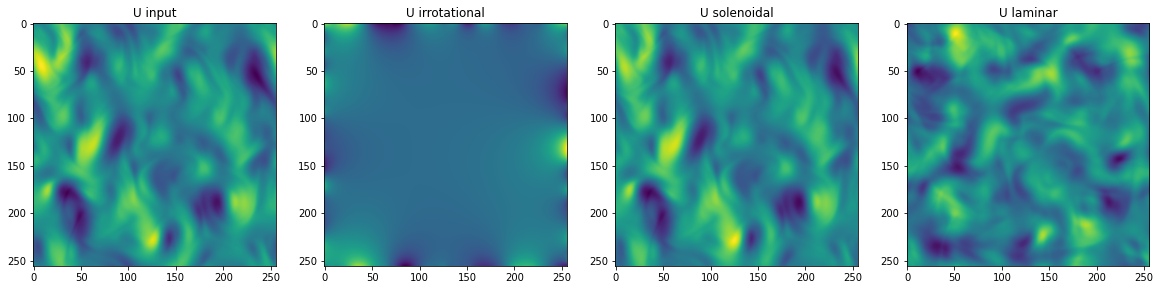

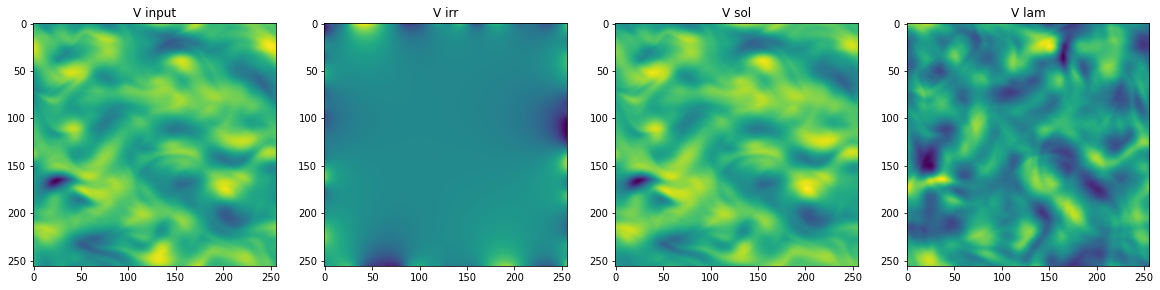

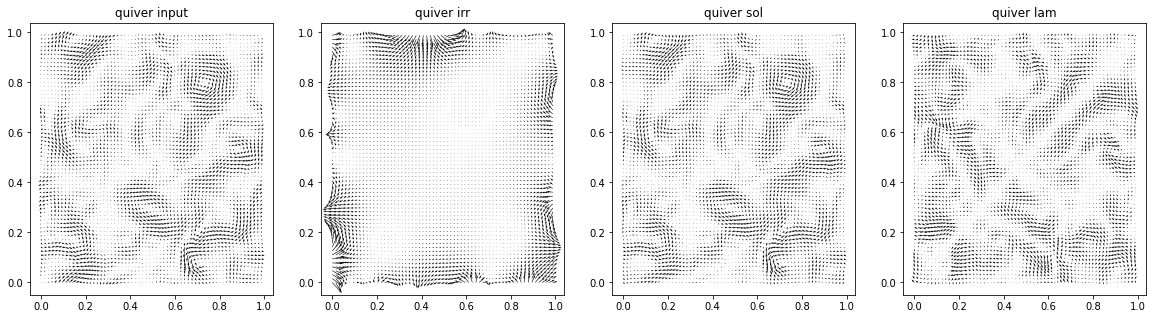

In [34]:
ds = 4

plt.figure(figsize=(20,10))
plt.subplot(141)
plt.title('U input')
plt.imshow(u)
plt.subplot(142)
plt.title('U irrotational')
plt.imshow(Uirr)
plt.subplot(143)
plt.title('U solenoidal')
plt.imshow(Usol)
plt.subplot(144)
plt.title('U laminar')
plt.imshow(Ulam)
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(141)
plt.title('V input')
plt.imshow(v)
plt.subplot(142)
plt.title('V irr')
plt.imshow(Virr)
plt.subplot(143)
plt.title('V sol')
plt.imshow(Vsol)
plt.subplot(144)
plt.title('V lam')
plt.imshow(Vlam)
plt.show()

plt.figure(figsize=(20,5))
plt.subplot(141)
plt.title('quiver input')
plt.quiver(x[::ds,::ds], y[::ds,::ds],
           u[::ds,::ds], v[::ds,::ds])
plt.subplot(142)
plt.title('quiver irr')
plt.quiver(x[::ds,::ds], y[::ds,::ds],
           Uirr[::ds,::ds], Virr[::ds,::ds])
plt.subplot(143)
plt.title('quiver sol')
plt.quiver(x[::ds,::ds], y[::ds,::ds],
           Usol[::ds,::ds], Vsol[::ds,::ds])
plt.subplot(144)
plt.title('quiver lam')
plt.quiver(x[::ds,::ds], y[::ds,::ds],
           Ulam[::ds,::ds], Vlam[::ds,::ds])
plt.show()

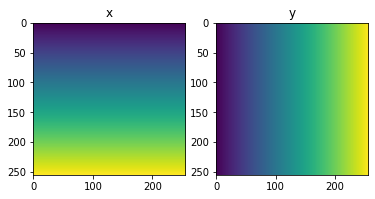

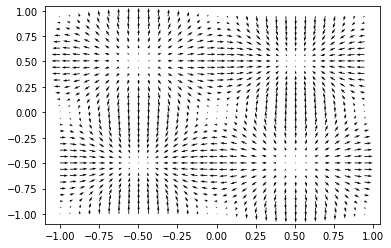

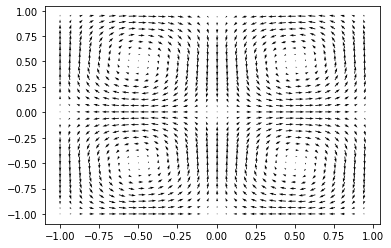

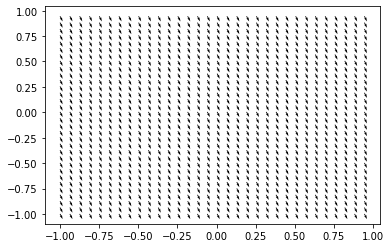

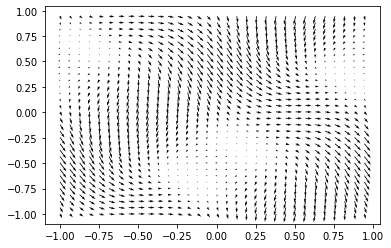

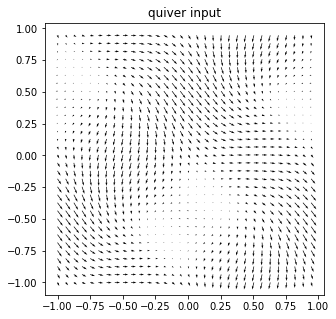

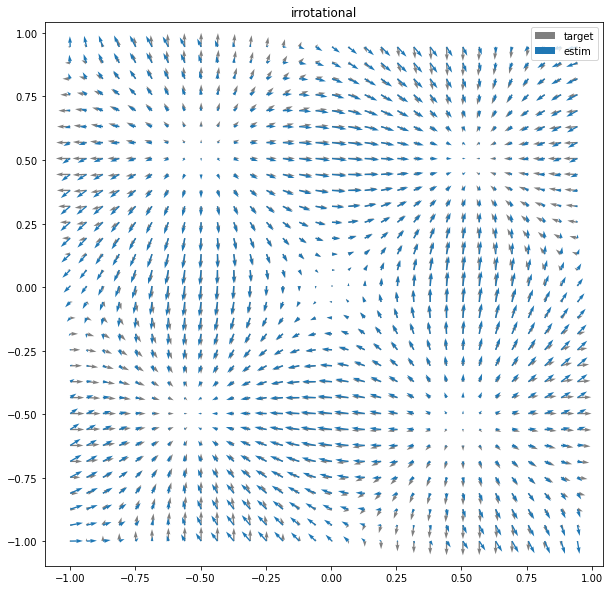

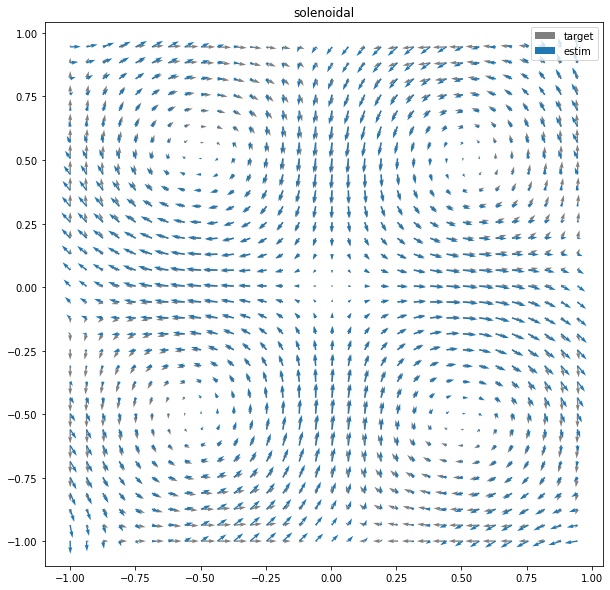

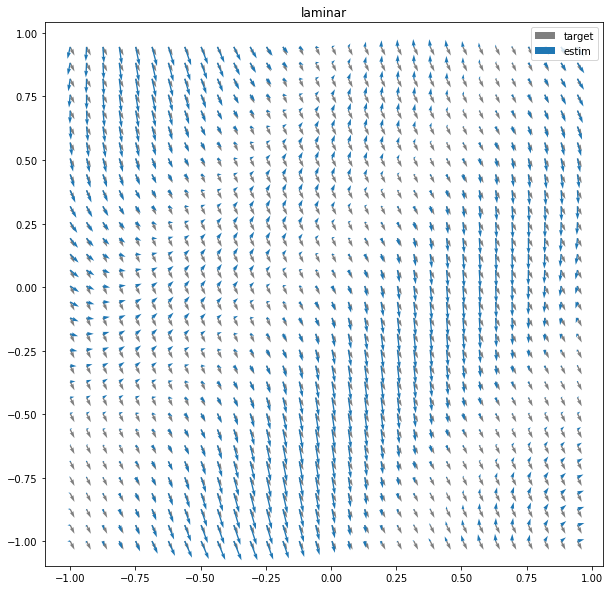

In [77]:
a = np.linspace(-1,1,256)
yy, xx = np.meshgrid(a,a)

plt.subplot(121)
plt.title('x')
plt.imshow(xx)
plt.subplot(122)
plt.title('y')
plt.imshow(yy)
plt.show()

ds = 8

u_irr = np.sin(np.pi*yy)*np.cos(np.pi*xx)
v_irr = np.sin(np.pi*xx)*np.cos(np.pi*yy)

plt.quiver(xx[::ds,::ds], yy[::ds,::ds],
           u_irr[::ds,::ds], v_irr[::ds,::ds])
plt.show()

u_sol = np.sin(np.pi*xx)*np.cos(np.pi*yy)
v_sol = -np.sin(np.pi*yy)*np.cos(np.pi*xx)

plt.quiver(xx[::ds,::ds], yy[::ds,::ds],
           u_sol[::ds,::ds], v_sol[::ds,::ds])
plt.show()

u_lam = 0.5 * np.ones_like(xx)
v_lam = -1 * np.ones_like(yy)

plt.quiver(xx[::ds,::ds], yy[::ds,::ds],
           u_lam[::ds,::ds], v_lam[::ds,::ds])
plt.show()

u_t = u_irr + u_sol + u_lam
v_t = v_irr + v_sol + v_lam

plt.quiver(xx[::ds,::ds], yy[::ds,::ds],
           u_t[::ds,::ds], v_t[::ds,::ds])
plt.show()

Uirr,Virr,Usol,Vsol,Ulam,Vlam,stf,fpt = decomposition(u_t.T, v_t.T, pad=10)
ds = 8

plt.figure(figsize=(5,5))
plt.title('quiver input')
plt.quiver(xx[::ds,::ds], yy[::ds,::ds],
           u_t[::ds,::ds], v_t[::ds,::ds])

plt.figure(figsize=(10,10))
plt.title('irrotational')
plt.quiver(xx[::ds,::ds], yy[::ds,::ds],
           u_irr[::ds,::ds], v_irr[::ds,::ds], color='k', alpha=0.5, label='target')
plt.quiver(xx[::ds,::ds], yy[::ds,::ds],
           Uirr[::ds,::ds], Virr[::ds,::ds], color='C0', label='estim')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.title('solenoidal')
plt.quiver(xx[::ds,::ds], yy[::ds,::ds],
           u_sol[::ds,::ds], v_sol[::ds,::ds], color='k', alpha=0.5, label='target')
plt.quiver(xx[::ds,::ds], yy[::ds,::ds],
           Usol[::ds,::ds], Vsol[::ds,::ds], color='C0', label='estim')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.title('laminar')
plt.quiver(xx[::ds,::ds], yy[::ds,::ds],
           u_lam[::ds,::ds], v_lam[::ds,::ds], color='k', alpha=0.5, label='target')
plt.quiver(xx[::ds,::ds], yy[::ds,::ds],
           Ulam[::ds,::ds], Vlam[::ds,::ds], color='C0', label='estim')
plt.legend()
plt.show()

Uirr_t,Virr_t,Usol_t,Vsol_t,Ulam_t,Vlam_t,stf_t,fpt_t = decomposition(u_t.T, v_t.T, pad=10)

In [14]:
import pynhhd as nhhd

0.007843137254901933
(256, 256, 2)


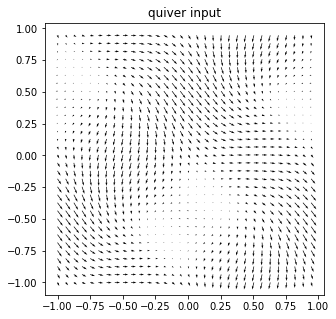

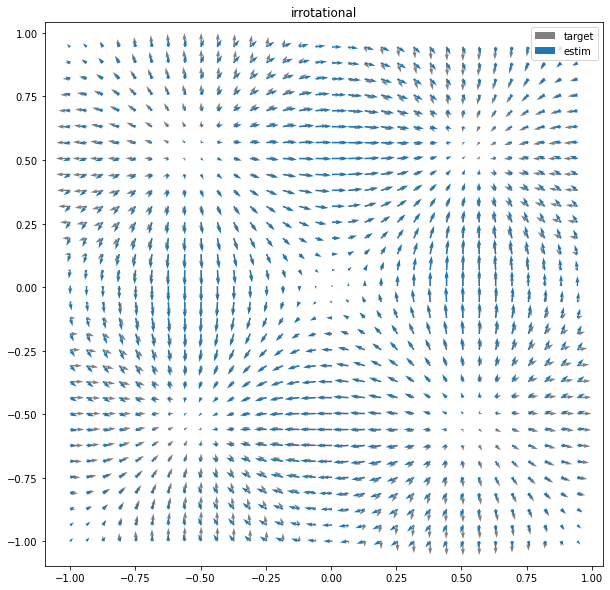

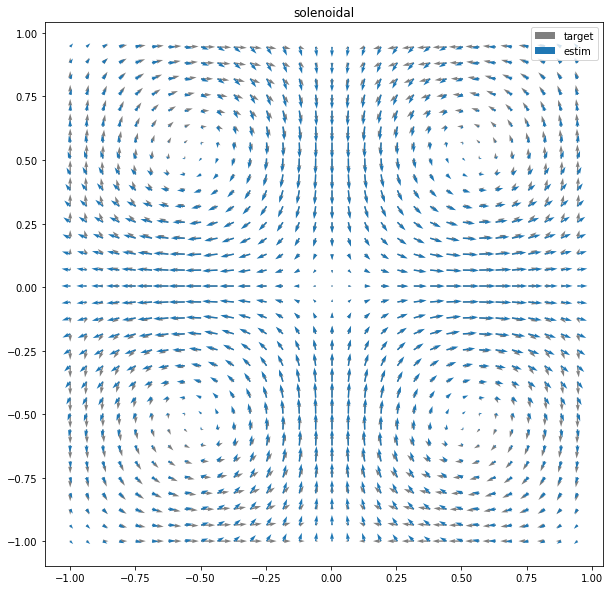

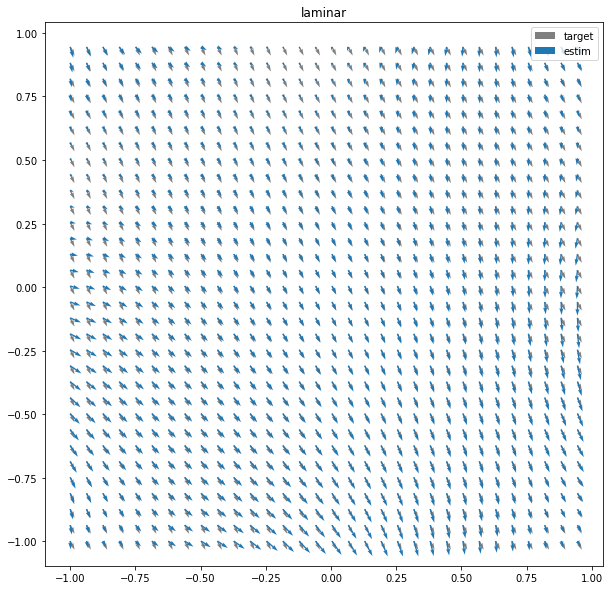

In [78]:
a = np.linspace(-1,1,256)
print(np.diff(a)[0])
xx, yy = np.meshgrid(a,a)

u_irr = np.sin(np.pi*yy)*np.cos(np.pi*xx)
v_irr = np.sin(np.pi*xx)*np.cos(np.pi*yy)

u_sol = np.sin(np.pi*xx)*np.cos(np.pi*yy)
v_sol = -np.sin(np.pi*yy)*np.cos(np.pi*xx)

u_lam = 0.5 * np.ones_like(xx)
v_lam = -1 * np.ones_like(yy)

u_t = u_irr + u_sol + u_lam
v_t = v_irr + v_sol + v_lam

fields = np.stack([u_t,v_t],axis=-1)
print(fields.shape)

hd = nhhd.nHHD(grid=u.shape,spacings=(np.diff(a)[0], np.diff(a)[0]))
hd.decompose(fields)

ds = 8

Uirr = hd.d[...,0]
Virr = hd.d[...,1]
Usol = hd.r[...,0]
Vsol = hd.r[...,1]
Ulam = hd.h[...,0]
Vlam = hd.h[...,1]
stf = hd.nD
fpt = hd.nRu


plt.figure(figsize=(5,5))
plt.title('quiver input')
plt.quiver(xx[::ds,::ds],  yy[::ds,::ds],
           u_t[::ds,::ds], v_t[::ds,::ds])
plt.figure(figsize=(10,10))
plt.title('irrotational')
plt.quiver(xx[::ds,::ds], yy[::ds,::ds],
           u_irr[::ds,::ds], v_irr[::ds,::ds], color='k', alpha=0.5, label='target')
plt.quiver(xx[::ds,::ds], yy[::ds,::ds],
           Uirr[::ds,::ds], Virr[::ds,::ds], color='C0', label='estim')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.title('solenoidal')
plt.quiver(xx[::ds,::ds], yy[::ds,::ds],
           u_sol[::ds,::ds], v_sol[::ds,::ds], color='k', alpha=0.5, label='target')
plt.quiver(xx[::ds,::ds], yy[::ds,::ds],
           Usol[::ds,::ds], Vsol[::ds,::ds], color='C0', label='estim')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.title('laminar')
plt.quiver(xx[::ds,::ds], yy[::ds,::ds],
           u_lam[::ds,::ds], v_lam[::ds,::ds], color='k', alpha=0.5, label='target')
plt.quiver(xx[::ds,::ds], yy[::ds,::ds],
           Ulam[::ds,::ds], Vlam[::ds,::ds], color='C0', label='estim')
plt.legend()
plt.show()

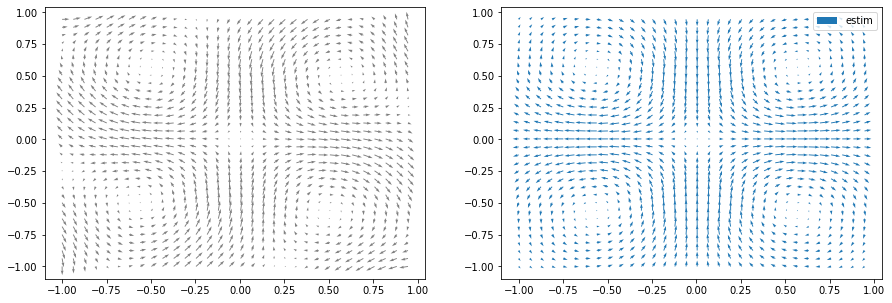

In [89]:
plt.figure(figsize=(15,5))
plt.title('solenoidal')
plt.subplot(121)
plt.quiver(xx[::ds,::ds], yy[::ds,::ds],
           Usol_t.T[::ds,::ds], Vsol_t.T[::ds,::ds], color='k', alpha=0.5, label='target')
plt.subplot(122)
plt.quiver(xx[::ds,::ds], yy[::ds,::ds],
           Usol[::ds,::ds], Vsol[::ds,::ds], color='C0', label='estim')
plt.legend()
plt.show()
